In [3]:
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
import keras
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
import time
import pickle
import sys
import csv
import IPython.display as ipd
import librosa
import librosa.display
import glob



from keras.utils import np_utils

from tensorflow.keras.layers import InputLayer, Dense, LSTM, Dropout, Activation
from tensorflow.keras.models import Sequential

from music21 import converter, instrument, note, chord, stream

FONTSIZE=18
plt.rcParams['figure.figsize']=(10,6)
plt.rcParams['font.size']=FONTSIZE

# For an introductory step, I'll train an LSTM on MIDI files by Chopin using a method from the following post
https://towardsdatascience.com/how-to-generate-music-using-a-lstm-neural-network-in-keras-68786834d4c5

In [18]:
notes=[]

for file in glob.glob('./MIDI_files/Classical_Archives_The_Greats/Chopin/Prelude*.mid'):
    print(file)
    midi=converter.parse(file)
    notes_to_parse=None
    
    parts = instrument.partitionByInstrument(midi)
    
    if parts: # file has instrument parts
        notes_to_parse = parts.parts[0].recurse()
        
    else: # file has notes in a flat structure
        notes_to_parse = midi.flat.notes 
        
    for element in notes_to_parse:
        
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
            
        elif isinstance(element, chord.Chord):
            notes.append('.'.join(str(n) for n in element.normalOrder))

./MIDI_files/Classical_Archives_The_Greats/Chopin/Prelude n17 op28 ''Scene On the Place of Notre Dame.mid
./MIDI_files/Classical_Archives_The_Greats/Chopin/Prelude n09 op28 ''Vision''.mid
./MIDI_files/Classical_Archives_The_Greats/Chopin/Prelude n10 op28 ''The Night Moth''.mid
./MIDI_files/Classical_Archives_The_Greats/Chopin/Prelude n02 op28 ''Presentiment of Death''.mid
./MIDI_files/Classical_Archives_The_Greats/Chopin/Prelude n19 op28.mid
./MIDI_files/Classical_Archives_The_Greats/Chopin/Prelude n16 op28 ''Hades''.mid
./MIDI_files/Classical_Archives_The_Greats/Chopin/Prelude n12 op28 ''Duel''.mid
./MIDI_files/Classical_Archives_The_Greats/Chopin/Prelude n04 op28 ''Suffocation''.mid
./MIDI_files/Classical_Archives_The_Greats/Chopin/Prelude n08 op28 ''Desparation''.mid
./MIDI_files/Classical_Archives_The_Greats/Chopin/Prelude n18 op28 ''Suicide''.mid
./MIDI_files/Classical_Archives_The_Greats/Chopin/Prelude n11 op28 ''Dragonfly''.mid
./MIDI_files/Classical_Archives_The_Greats/Chopin/P

In [19]:
notes[:20]

['C4',
 '3.8',
 'C4',
 '3.8',
 'C4',
 '3.8',
 'C4',
 '3.8',
 'C4',
 '3.8',
 'C4',
 '3.8',
 'C4',
 '3.8',
 'C4',
 '3.8',
 'C4',
 '3.8',
 'C4',
 '3.8']

In [20]:
sequence_length=100
n_vocab=len(set(notes))

#get all pitch names
pitchnames=sorted(set(item for item in notes))

# create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

network_input = []
network_output = []# create input sequences and the corresponding outputs
for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])
    n_patterns = len(network_input)# reshape the input into a format compatible with LSTM layers
network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
# normalize input
network_input = network_input / float(n_vocab)
network_output = np_utils.to_categorical(network_output)

In [21]:
print(n_vocab)

244


In [7]:
print(network_input.shape)
print(network_output.shape)

(14031, 100, 1)
(14031, 244)


In [8]:
num_train=int(network_input.shape[0]*0.75)
num_validation=network_input.shape[0]-num_train

idx_all=np.arange(network_input.shape[0])
idx_train=np.random.choice(idx_all,num_train,replace=False)
idx_validation=[]
for i in idx_all:
    if i not in idx_train:
        idx_validation.append(i)
        
        
ins_train=network_input[idx_train,:,:]
outs_train=network_output[idx_train,:]

ins_validation=network_input[idx_validation,:,:]
outs_validation=network_output[idx_validation,:]


In [9]:
print(ins_train.shape)
print(outs_train.shape)
print(ins_validation.shape)
print(outs_validation.shape)

(10523, 100, 1)
(10523, 244)
(3508, 100, 1)
(3508, 244)


In [11]:
training_data={'ins_train':ins_train,'outs_train':outs_train,'ins_validation':ins_validation,'outs_validation':outs_validation}
fp=open("training_data.pkl",'wb')
pickle.dump(training_data,fp)
fp.close()

In [6]:
model = Sequential()
model.add(LSTM(256,
               input_shape=(100, 1),
               return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(244))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 256)          264192    
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 256)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 512)          1574912   
_________________________________________________________________
dropout_4 (Dropout)          (None, 100, 512)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)              

In [9]:
# Callbacks
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True,
                                                  min_delta=0.01)

In [ ]:
history=model.fit(ins_train, 
                  outs_train,
                  validation_data=(ins_validation, outs_validation),
                  epochs=50, 
                  batch_size=64,
                  callbacks=[early_stopping_cb])

Train on 10523 samples, validate on 3508 samples
Epoch 1/50
10523/10523 [==============================] - 249s 24ms/sample - loss: 4.7451 - categorical_accuracy: 0.0282 - val_loss: 4.6507 - val_categorical_accuracy: 0.0305
Epoch 2/50
10523/10523 [==============================] - 266s 25ms/sample - loss: 4.5724 - categorical_accuracy: 0.0337 - val_loss: 4.5061 - val_categorical_accuracy: 0.0379
Epoch 3/50
10523/10523 [==============================] - 255s 24ms/sample - loss: 4.5086 - categorical_accuracy: 0.0383 - val_loss: 4.5431 - val_categorical_accuracy: 0.0271
Epoch 4/50
10523/10523 [==============================] - 271s 26ms/sample - loss: 4.6380 - categorical_accuracy: 0.0359 - val_loss: 4.6912 - val_categorical_accuracy: 0.0305
Epoch 5/50
10523/10523 [==============================] - 258s 24ms/sample - loss: 4.6399 - categorical_accuracy: 0.0368 - val_loss: 4.6820 - val_categorical_accuracy: 0.0305
Epoch 6/50
10523/10523 [==============================] - 241s 23ms/sample -

# I sent this over to oscer to train faster, loading the results back in here

In [6]:
fp = open('training_data.pkl', "rb")
training_data = pickle.load(fp)
fp.close()

ins_train=training_data['ins_train']
outs_train=training_data['outs_train']
ins_validation=training_data['ins_validation']
outs_validation=training_data['outs_validation']
n_vocab=244

In [7]:
model = Sequential()
model.add(LSTM(256,
               input_shape=(ins_train.shape[1], ins_train.shape[2]),
               return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(n_vocab))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['categorical_accuracy'])

model.load_weights('./results/Chopin_Prelude_Model1_weights.h5')

In [8]:
fp = open('./results/Chopin_Prelude_Model1_results.pkl', "rb")
results = pickle.load(fp)
fp.close()

history=results['history']

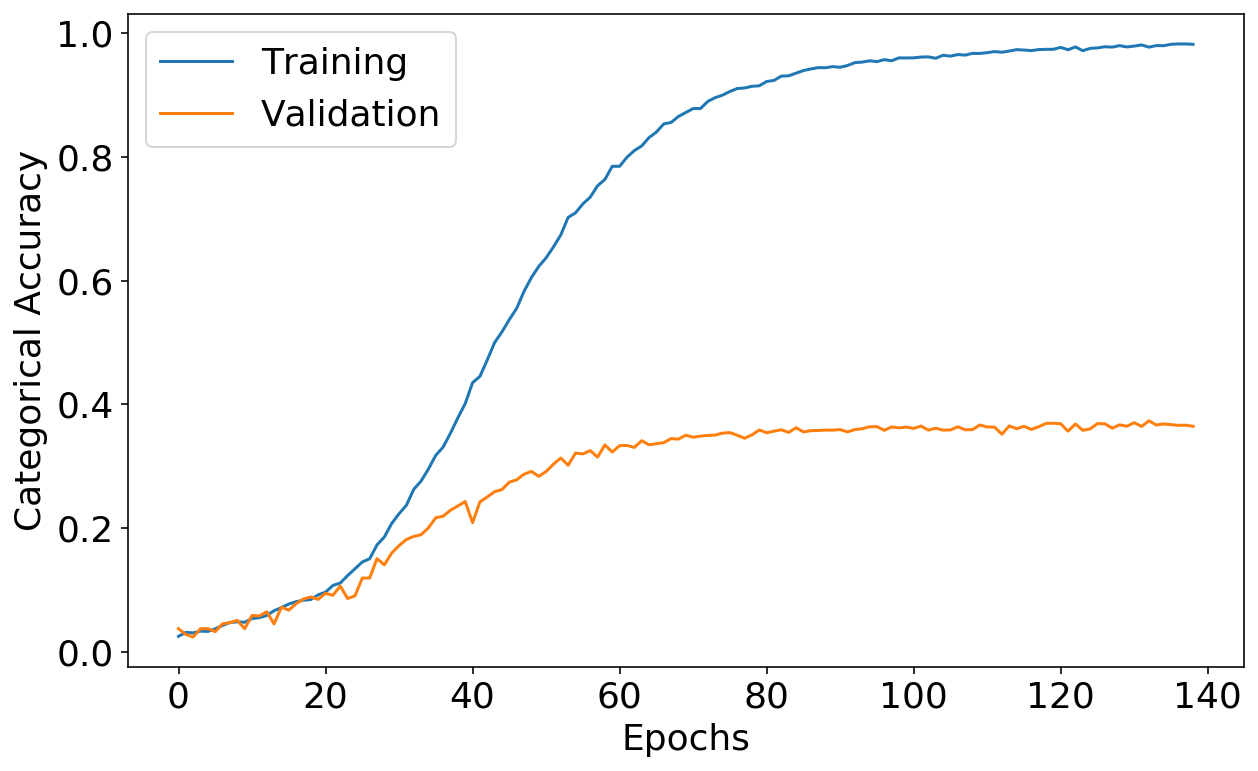

In [10]:
epochs=np.arange(len(history['categorical_accuracy']))
plt.plot(epochs,history['categorical_accuracy'],label='Training')
plt.plot(epochs,history['val_categorical_accuracy'],label='Validation')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='upper left')

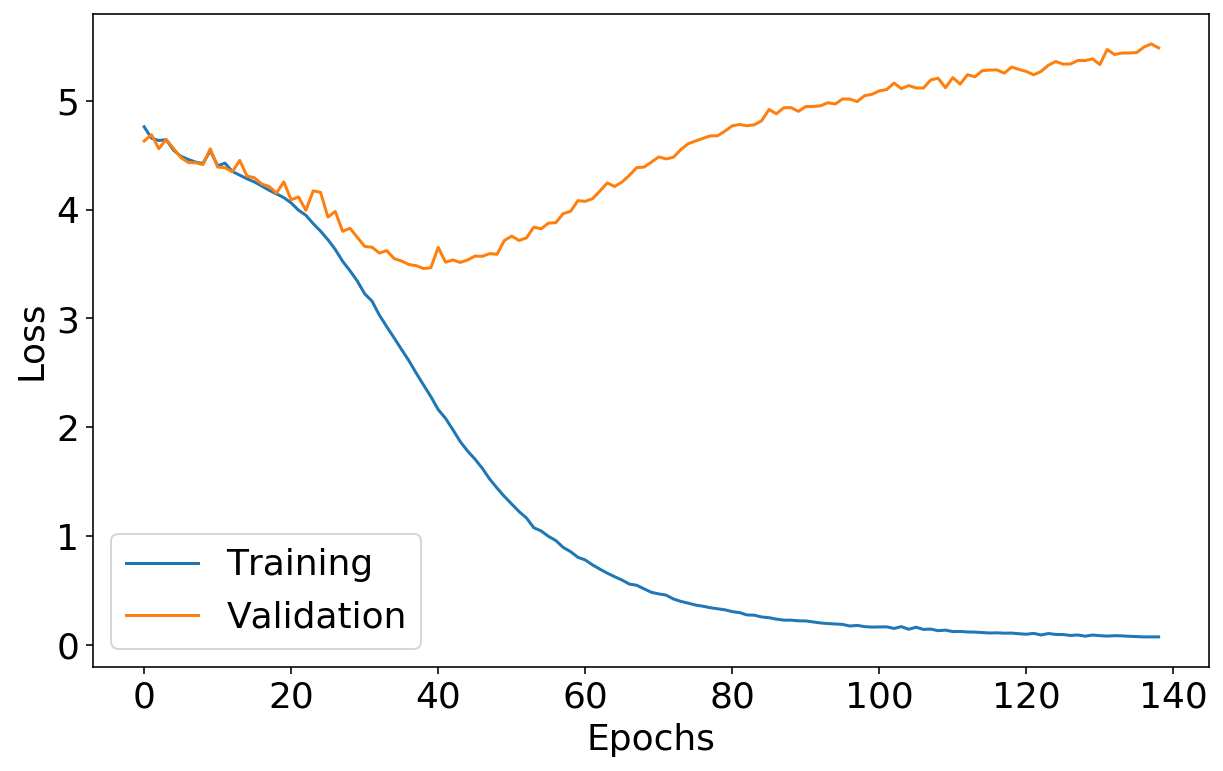

In [11]:

plt.plot(epochs,history['loss'],label='Training')
plt.plot(epochs,history['val_loss'],label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='best')

In [36]:
start = np.random.randint(0, len(ins_train)-1)
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
pattern = ins_train[start]
prediction_output = []
# generate 500 notes
for note_index in range(500):
    prediction_input = np.reshape(pattern, (1, len(pattern), 1))
    prediction_input = prediction_input / float(n_vocab)    
    prediction = model.predict(prediction_input, verbose=0)    
    index = np.argmax(prediction)
    result = int_to_note[index]
    prediction_output.append(result)    
    pattern=np.append(pattern,index)
    pattern = pattern[1:len(pattern)]

In [37]:
offset=0
output_notes=[]

for pattern in prediction_output:
    
    if ('.' in pattern) or pattern.isdigit():
        #pattern is a chord
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    else:
        #pattern is a note
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)
        
    # increase offset each iteration so that notes do not stack
    offset += 0.5

In [38]:
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='./Generated_MIDIs/Chopin_Prelude1.mid')

'./Generated_MIDIs/Chopin_Prelude1.mid'